In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

target_path = 'Targets/daily_crsp_sanitized.csv'

In [2]:
daily = pd.read_csv(target_path, nrows=1000000)
daily.head()

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
0,2000-01-03,5,15580,6320,0,0.000000,-0.009549
1,2000-01-03,7,14593,3573,0,0.088754,-0.009549
2,2000-01-03,25,62770,6711,0,-0.061489,-0.009549
3,2000-01-03,29,59184,2082,0,-0.012346,-0.009549
4,2000-01-03,33,59248,2082,0,-0.034524,-0.009549


In [3]:
daily.tail()

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
999995,2000-06-23,9030,11183,3670,0,0.000000,-0.007368
999996,2000-06-23,9033,11185,7011,0,-0.030303,-0.007368
999997,2000-06-23,9036,11187,6330,0,-0.009901,-0.007368
999998,2000-06-23,9044,11194,3690,0,-0.026316,-0.007368
999999,2000-06-23,9046,62084,6210,0,0.014925,-0.007368


# Gradient descent on rolling window of returns

We will use a rolling window of past returns and apply gradient descent on this rolling window to predict future returns. 
We then use the future returns as weights to our trading strategy and compute the Sharpe ratio. 

In [4]:
window_size = 10  # number of past days to use

# Create lagged features for each stock
df_lagged = daily[['date', 'PERMNO', 'DlyRet']].copy()

for lag in range(1, window_size + 1):
    df_lagged[f'ret_lag{lag}'] = df_lagged.groupby('PERMNO')['DlyRet'].shift(lag)

# Drop rows with NaNs due to lagging
df_lagged = df_lagged.dropna()

# Inputs: ret_lag1, ..., ret_lag5
# Target: DlyRet (next-day return)
feature_cols = [f'ret_lag{i}' for i in range(1, window_size + 1)]
X = df_lagged[feature_cols].values
y = df_lagged['DlyRet'].values

df_lagged.head()

,date,PERMNO,DlyRet,ret_lag1,ret_lag2,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,ret_lag8,ret_lag9,ret_lag10
83524,2000-01-18,15580,-0.064103,0.026316,0.027027,0.000000,-0.026316,0.000000,0.027027,-0.051282,0.026316,0.027027,0.000000
83525,2000-01-18,14593,0.034848,0.038114,0.109677,-0.059973,-0.051151,-0.017588,0.047368,-0.086538,0.014634,-0.084310,0.088754
83526,2000-01-18,62770,-0.048276,0.024735,0.021661,-0.003597,-0.007143,-0.066667,0.023891,0.039007,-0.003534,-0.024138,-0.061489
83527,2000-01-18,59184,-0.024765,-0.014310,-0.018993,0.028887,-0.012584,-0.021346,0.021812,0.014468,0.046305,0.002679,-0.012346
83528,2000-01-18,59248,-0.030525,-0.028470,0.039457,0.009963,-0.013514,-0.038961,0.021713,-0.011919,0.047441,-0.012330,-0.034524


In [5]:
df_lagged.tail()

,date,PERMNO,DlyRet,ret_lag1,ret_lag2,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,ret_lag8,ret_lag9,ret_lag10
999995,2000-06-23,11183,0.000000,-0.019608,-0.056881,0.009259,0.038462,0.050505,0.000000,-0.091743,0.112245,0.026178,-0.025510
999996,2000-06-23,11185,-0.030303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029412,-0.028571,0.000000,-0.027778
999997,2000-06-23,11187,-0.009901,-0.004926,0.030457,-0.015000,0.015228,-0.015000,-0.019608,0.000000,0.000000,0.062500,-0.094340
999998,2000-06-23,11194,-0.026316,0.000000,0.000000,0.000000,-0.037975,0.000000,0.000000,0.000000,0.000000,0.000000,-0.012500
999999,2000-06-23,62084,0.014925,0.000000,0.000000,-0.014706,0.000000,0.000000,0.000000,0.000000,0.030303,-0.029412,0.000000


In [6]:
df_lagged = df_lagged.reset_index(drop=True).sort_values('date')
unique_dates = df_lagged['date'].unique()

# Use 2/3 of the data for training and 1/3 for evaluating the strategy
n_train = int(len(unique_dates) * 2 / 3)

train_dates = unique_dates[:n_train]
test_dates = unique_dates[n_train:]

train_df = df_lagged[df_lagged['date'].isin(train_dates)]
test_df = df_lagged[df_lagged['date'].isin(test_dates)]

X_train = train_df[feature_cols].values
y_train = train_df['DlyRet'].values

X_test = test_df[feature_cols].values
y_test = test_df['DlyRet'].values



In [7]:

# Convert data to torch tensors 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)


In [8]:
# Define simple MLP
class ReturnForecaster(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze()

model = ReturnForecaster(input_dim=X_train.shape[1])

# Use Adam gradient descent for optimal performance
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# MSE loss, can do better?
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(10):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor)
        mse = loss_fn(preds, y_test_tensor)
        print(f"Epoch {epoch}: Test MSE = {mse.item():.6f}")


Epoch 0: Test MSE = 0.002890
Epoch 1: Test MSE = 0.002886
Epoch 2: Test MSE = 0.002893
Epoch 3: Test MSE = 0.002889
Epoch 4: Test MSE = 0.002885
Epoch 5: Test MSE = 0.002891
Epoch 6: Test MSE = 0.002897
Epoch 7: Test MSE = 0.002901
Epoch 8: Test MSE = 0.002882
Epoch 9: Test MSE = 0.002889


In [9]:
# Compute model predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_true_test = y_test_tensor.numpy()


In [14]:

# Daily strategy return = signal * actual return
strategy_returns = y_pred_test * y_true_test

# Get dates from test_df (aligned with y_test)
dates_test = test_df['date'].values

# Combine into DataFrame
strategy_df = pd.DataFrame({
    'date': dates_test,
    'strategy_ret': strategy_returns
})

display(strategy_df)

# Group by date to compute daily PnL across all stocks assuming equal investment in all stocks
daily_returns = strategy_df.groupby('date')['strategy_ret'].mean()

# Sharpe Ratio calculation
# Since returns are daily, and there are 250 trading days a year, we multiply by 1/sqrt(250)
mean_ret = daily_returns.mean()
std_ret = daily_returns.std()
sharpe_ratio = (1/np.sqrt(250)) * mean_ret / (std_ret + 1e-8)

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


,date,strategy_ret
0,2000-05-03,4.062949e-06
1,2000-05-03,-8.529756e-05
2,2000-05-03,-1.450597e-06
3,2000-05-03,1.737639e-04
4,2000-05-03,9.067393e-07
...,...,...
299782,2000-06-23,-1.126488e-04
299783,2000-06-23,7.161462e-05
299784,2000-06-23,-2.324079e-04
299785,2000-06-23,0.000000e+00


Sharpe Ratio: 0.0437


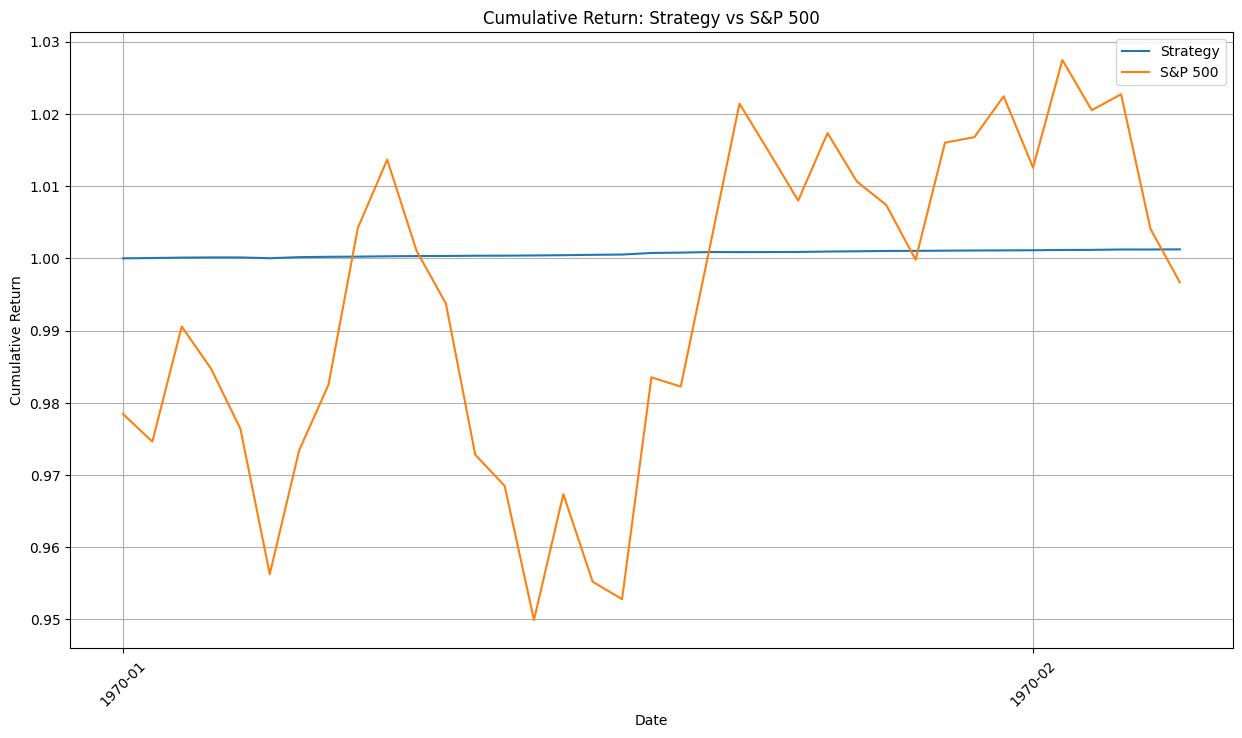

In [15]:
# Compute cumulative return of the strategy
cumulative_returns = (1 + daily_returns).cumprod()

# Prepare S&P 500 cumulative returns
sp500 = daily[['date', 'sprtrn']].drop_duplicates("date")
sp500 = sp500[sp500.date >= strategy_df['date'].iloc[0]].reset_index(drop=True)
sp500["cumulative_1dollar"] = (1 + sp500['sprtrn']).cumprod()

# Align strategy cumulative returns with dates
cumulative_df = pd.DataFrame({
    'date': daily_returns.index,
    'strategy': cumulative_returns.values
}).merge(sp500[['date', 'cumulative_1dollar']], on='date', how='inner')

# Plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=cumulative_df, x='date', y='strategy', label='Strategy')
sns.lineplot(data=cumulative_df, x='date', y='cumulative_1dollar', label='S&P 500')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return: Strategy vs S&P 500")
plt.legend()
plt.grid(True)

# Format the x-axis to show fewer, rotated dates
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.show()

